# Решение тестового задания
Выполнил Ларькин Владимир ([телеграм](https://t.me/vlarkin))

In [1]:
import pandas as pd
import seaborn as sns
import sklearn
import numpy as np
import tqdm

import matplotlib.pyplot as plt
import matplotlib

from catalyst import utils
utils.set_global_seed(42)

%matplotlib inline

sns.set_theme()
matplotlib.rcParams['figure.figsize'] = (20, 10)

## Загрузка данных

In [2]:
df = pd.read_csv("ds.txt", sep="\t", header=None)  # ds.txt — файл с данными

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.155051,0.974187,0.074675,0.442146,0.369443,0.468138,0.578846,0.422744,0.931543,0.474148,15
1,0.968379,0.716820,0.678846,0.510049,0.545299,0.573692,0.817491,0.206636,0.880111,0.574187,17
2,0.468263,0.405603,0.320325,0.468084,0.100995,0.974407,0.300062,0.608356,0.050082,0.762011,12
3,0.776820,0.103740,0.373748,0.797782,0.906810,0.599069,0.626680,0.924705,0.632768,0.512663,16
4,0.407886,0.415357,0.101543,0.935160,0.444124,0.193607,0.656837,0.599929,0.868582,0.405406,20


Посмотрим на типы данных:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1000 non-null   float64
 1   1       1000 non-null   float64
 2   2       1000 non-null   float64
 3   3       1000 non-null   float64
 4   4       1000 non-null   float64
 5   5       1000 non-null   float64
 6   6       1000 non-null   float64
 7   7       1000 non-null   float64
 8   8       1000 non-null   float64
 9   9       1000 non-null   float64
 10  10      1000 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 86.1 KB


Как видим, данные представляют собой числа, проверим теперь на наличие nan-ов:

In [5]:
df.isna().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
dtype: int64

nan-ов не обнаружено, посмотрим на матожидание и стандартное отклонение:

In [6]:
ms = pd.concat([df.mean(), df.std()], axis=1)
ms.columns = ["mean", "std"]
ms

,mean,std
0,0.490491,0.293920
1,0.499785,0.278833
2,0.496466,0.298024
3,0.503167,0.284102
4,0.508902,0.283300
5,0.513466,0.291059
6,0.487111,0.288407
7,0.498870,0.285954
8,0.505611,0.283131
9,0.499113,0.284073


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

Посмотрим на корреляции между переменными:

In [8]:
df.corr().style.background_gradient(cmap='coolwarm').set_precision(5)

,0,1,2,3,4,5,6,7,8,9,10
0,1.00000,-0.03084,0.00145,-0.01544,0.00711,-0.01449,-0.03316,0.00799,-0.01345,-0.00732,0.42999
1,-0.03084,1.00000,0.00096,0.01674,-0.05518,-0.02388,-0.02469,0.00877,0.03195,-0.05087,0.37014
2,0.00145,0.00096,1.00000,0.03112,-0.03766,0.02237,0.01670,0.06033,0.01149,0.01353,-0.00885
3,-0.01544,0.01674,0.03112,1.00000,-0.06231,-0.02141,0.00314,-0.01252,0.00132,-0.04288,0.55923
4,0.00711,-0.05518,-0.03766,-0.06231,1.00000,0.05201,0.02414,0.01329,-0.05265,0.01776,0.25227
5,-0.01449,-0.02388,0.02237,-0.02141,0.05201,1.00000,-0.03563,-0.01614,-0.04746,-0.01461,-0.00547
6,-0.03316,-0.02469,0.01670,0.00314,0.02414,-0.03563,1.00000,0.01245,0.10268,0.01390,-0.02801
7,0.00799,0.00877,0.06033,-0.01252,0.01329,-0.01614,0.01245,1.00000,0.00392,0.04508,0.00128
8,-0.01345,0.03195,0.01149,0.00132,-0.05265,-0.04746,0.10268,0.00392,1.00000,-0.02068,-0.01883
9,-0.00732,-0.05087,0.01353,-0.04288,0.01776,-0.01461,0.01390,0.04508,-0.02068,1.00000,-0.06279


Сильных корреляций между переменными не обнаружено, а вот $x_2$, $x_5$, $x_7$ слабее всего коррелируют со значением функции.

## Подготовка данных

In [9]:
dw = df.drop([10], axis=1)  # в матрицу X пойдёт весь датасет, кроме последнего столбца

X = dw.values
y = df[10].values  # вектор y -- последний столбец таблицы

y.shape, X.shape

((1000,), (1000, 10))

Разобьём датасет на train и test выборки:

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Критерий качества

Так как мы решаем задачу регрессии, то будем пользоваться метриками MSE (средний квадрат ошибки) и $R^2$ (коэффициент детерминации). MSE будем минимизировать при обучении, а финальный контроль качества на тестовой выборке определим по $R^2$ — чем она ближе к единице, тем точнее модель.

In [11]:
def print_metrics(y_true, y_pred):
    print(f'R^2: {r2_score(y_true, y_pred)}')
    print(f'MSE: {mean_squared_error(y_true, y_pred)}')

In [12]:
def plot_test_pred(test, pred, title=""):
    """Строит на одном графике исходную функцию и предсказания модели"""
    x = np.array(range(len(test)))
    plt.plot(x, np.array(test), label="Истинные значения")
    plt.plot(x, np.array(pred), label="Предсказанные значения")
    plt.title(title)
    plt.legend()

## Эксперименты с различными ML-моделями

Попробуем для начала линейную регрессию — одну из простейших моделей. Перед обучением нормируем данные.

In [13]:
lr = LinearRegression()
ss = StandardScaler()
X_train_s = ss.fit_transform(X_train, y_train)
lr.fit(X_train_s, y_train)

pred = lr.predict(ss.transform(X_test))

R^2: 0.7398141708838135
MSE: 6.417476970505012


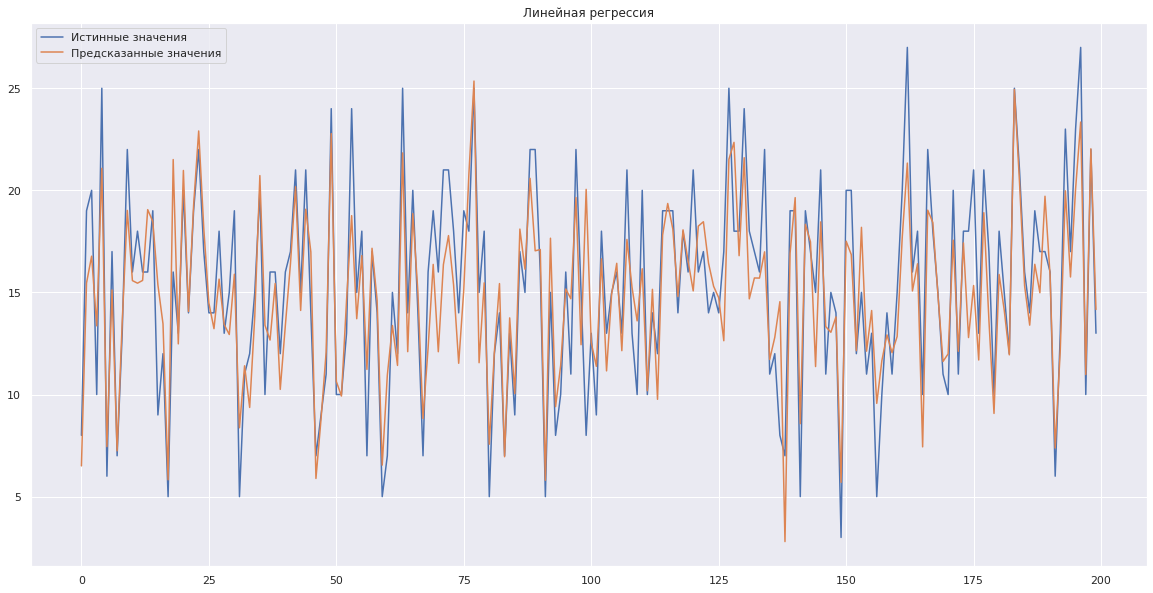

In [14]:
plot_test_pred(y_test, pred, "Линейная регрессия")
print_metrics(y_test, pred)

Попробуем теперь случайный лес, параметры для которого найдём поиском по сетке.

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor(random_state=42, n_jobs=-1, verbose=0)

grid = {
    "n_estimators": [200],
    "max_depth": np.arange(10, 30, 1),
}

gs = GridSearchCV(model, grid, cv=3)

gs.fit(X_train, y_train)

model = gs.best_estimator_

pred = model.predict(X_test)

In [16]:
gs.best_params_

{'max_depth': 19, 'n_estimators': 200}

R^2: 0.8673666240968692
MSE: 3.271398900816326


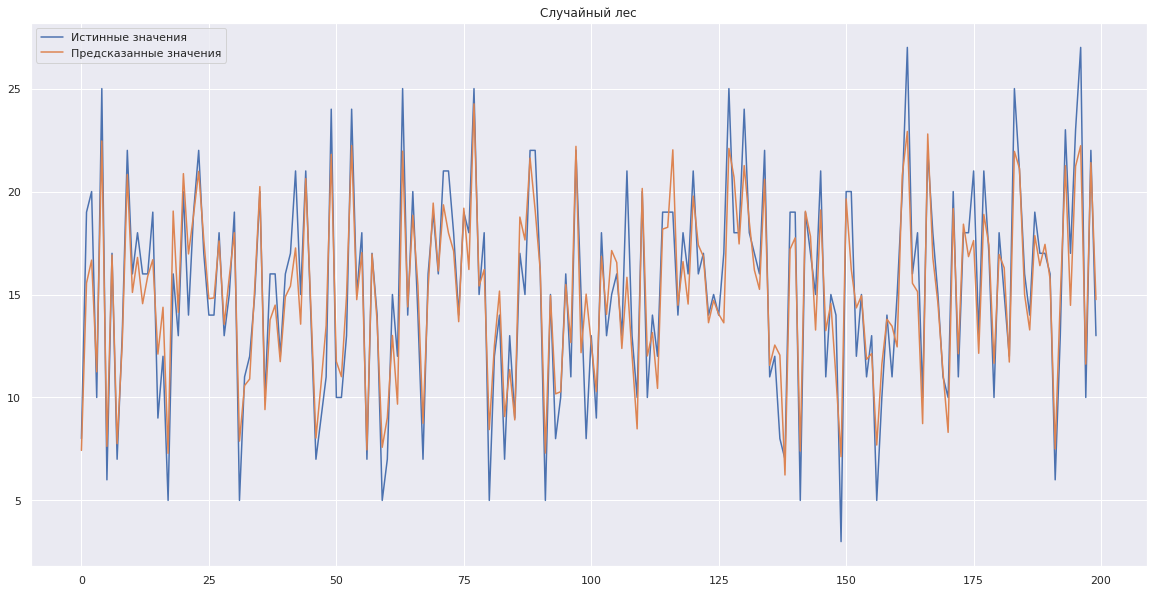

In [17]:
plot_test_pred(y_test, pred, "Случайный лес")
print_metrics(y_test, pred)

Результат уже сильно лучше. Теперь попробуем градиентный бустинг, а именно, его реализацию из пакета `catboost`:

In [18]:
import catboost

In [19]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((800, 10), (800,), (200, 10), (200,))

В `catboost`'е не реализована MSE, поэтому будем минимизировать RMSE, представляющую собой $\sqrt{\text{MSE}}$. В силу того, что $\sqrt{x}$ монотонно возрастает, экстремумы RMSE совпадают с экстремумами MSE, так что в данном случае для нас нет никакой разницы, что из них использовать.

In [20]:
model = catboost.CatBoostRegressor(random_seed=42, loss_function="RMSE")

grid = {
    "learning_rate": [0.1],
    "depth": range(3, 7),
    "l2_leaf_reg": np.arange(0.55, 0.65, .02),
    "iterations": range(120, 200, 40),
}

params = model.grid_search(grid, X_train, y_train, plot=True)["params"]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 14.2348915	test: 14.3418435	best: 14.3418435 (0)	total: 46.5ms	remaining: 5.53s
1:	learn: 12.9691379	test: 13.0783087	best: 13.0783087 (1)	total: 47.3ms	remaining: 2.79s
2:	learn: 11.8487407	test: 11.9647839	best: 11.9647839 (2)	total: 47.9ms	remaining: 1.87s
3:	learn: 10.8063864	test: 10.9012180	best: 10.9012180 (3)	total: 48.3ms	remaining: 1.4s
4:	learn: 9.9237284	test: 10.0270215	best: 10.0270215 (4)	total: 49.5ms	remaining: 1.14s
5:	learn: 9.1219698	test: 9.2385225	best: 9.2385225 (5)	total: 50.3ms	remaining: 957ms
6:	learn: 8.3954630	test: 8.5096134	best: 8.5096134 (6)	total: 51.1ms	remaining: 825ms
7:	learn: 7.7340090	test: 7.8279183	best: 7.8279183 (7)	total: 51.8ms	remaining: 725ms
8:	learn: 7.1408920	test: 7.2400842	best: 7.2400842 (8)	total: 52.6ms	remaining: 648ms
9:	learn: 6.5972914	test: 6.7072839	best: 6.7072839 (9)	total: 53.3ms	remaining: 586ms
10:	learn: 6.1495082	test: 6.2382231	best: 6.2382231 (10)	total: 54.2ms	remaining: 537ms
11:	learn: 5.7594095	test: 5

84:	learn: 1.0543171	test: 1.3209876	best: 1.3209876 (84)	total: 31.8ms	remaining: 13.1ms
85:	learn: 1.0483451	test: 1.3161379	best: 1.3161379 (85)	total: 32.2ms	remaining: 12.7ms
86:	learn: 1.0432084	test: 1.3132242	best: 1.3132242 (86)	total: 32.6ms	remaining: 12.4ms
87:	learn: 1.0371033	test: 1.3052045	best: 1.3052045 (87)	total: 32.9ms	remaining: 12ms
88:	learn: 1.0303821	test: 1.3012995	best: 1.3012995 (88)	total: 33.3ms	remaining: 11.6ms
89:	learn: 1.0242702	test: 1.2962549	best: 1.2962549 (89)	total: 34ms	remaining: 11.3ms
90:	learn: 1.0176660	test: 1.2873597	best: 1.2873597 (90)	total: 34.6ms	remaining: 11ms
91:	learn: 1.0110824	test: 1.2842871	best: 1.2842871 (91)	total: 35.2ms	remaining: 10.7ms
92:	learn: 1.0046781	test: 1.2768028	best: 1.2768028 (92)	total: 35.9ms	remaining: 10.4ms
93:	learn: 0.9935306	test: 1.2668543	best: 1.2668543 (93)	total: 36.5ms	remaining: 10.1ms
94:	learn: 0.9890169	test: 1.2600188	best: 1.2600188 (94)	total: 37.1ms	remaining: 9.77ms
95:	learn: 0.959

113:	learn: 0.8150599	test: 1.1178300	best: 1.1178300 (113)	total: 42.3ms	remaining: 17.1ms
114:	learn: 0.8110289	test: 1.1164999	best: 1.1164999 (114)	total: 42.7ms	remaining: 16.7ms
115:	learn: 0.8063340	test: 1.1111211	best: 1.1111211 (115)	total: 43.1ms	remaining: 16.3ms
116:	learn: 0.7895487	test: 1.0906159	best: 1.0906159 (116)	total: 43.4ms	remaining: 16ms
117:	learn: 0.7864799	test: 1.0879039	best: 1.0879039 (117)	total: 43.8ms	remaining: 15.6ms
118:	learn: 0.7752933	test: 1.0750365	best: 1.0750365 (118)	total: 44.1ms	remaining: 15.2ms
119:	learn: 0.7720015	test: 1.0739548	best: 1.0739548 (119)	total: 44.8ms	remaining: 14.9ms
120:	learn: 0.7678254	test: 1.0690906	best: 1.0690906 (120)	total: 45.5ms	remaining: 14.7ms
121:	learn: 0.7644674	test: 1.0647652	best: 1.0647652 (121)	total: 45.9ms	remaining: 14.3ms
122:	learn: 0.7601778	test: 1.0619151	best: 1.0619151 (122)	total: 46.6ms	remaining: 14ms
123:	learn: 0.7576677	test: 1.0592488	best: 1.0592488 (123)	total: 47.3ms	remaining:

100:	learn: 0.9242404	test: 1.2119046	best: 1.2119046 (100)	total: 36ms	remaining: 21.1ms
101:	learn: 0.9199795	test: 1.2117735	best: 1.2117735 (101)	total: 36.7ms	remaining: 20.8ms
102:	learn: 0.9160089	test: 1.2060161	best: 1.2060161 (102)	total: 37.2ms	remaining: 20.6ms
103:	learn: 0.9101525	test: 1.1989111	best: 1.1989111 (103)	total: 37.8ms	remaining: 20.3ms
104:	learn: 0.9060307	test: 1.1957476	best: 1.1957476 (104)	total: 38.4ms	remaining: 20.1ms
105:	learn: 0.8889370	test: 1.1817511	best: 1.1817511 (105)	total: 48.4ms	remaining: 24.7ms
106:	learn: 0.8797610	test: 1.1756591	best: 1.1756591 (106)	total: 49.2ms	remaining: 24.4ms
107:	learn: 0.8760513	test: 1.1720974	best: 1.1720974 (107)	total: 49.7ms	remaining: 23.9ms
108:	learn: 0.8713349	test: 1.1703403	best: 1.1703403 (108)	total: 50.4ms	remaining: 23.6ms
109:	learn: 0.8662159	test: 1.1638498	best: 1.1638498 (109)	total: 51ms	remaining: 23.2ms
110:	learn: 0.8631286	test: 1.1636295	best: 1.1636295 (110)	total: 51.6ms	remaining:

68:	learn: 0.9733284	test: 1.3217113	best: 1.3217113 (68)	total: 34.1ms	remaining: 25.2ms
69:	learn: 0.9423512	test: 1.2948081	best: 1.2948081 (69)	total: 34.9ms	remaining: 24.9ms
70:	learn: 0.9270560	test: 1.2801930	best: 1.2801930 (70)	total: 35.6ms	remaining: 24.5ms
71:	learn: 0.9185836	test: 1.2761813	best: 1.2761813 (71)	total: 36.4ms	remaining: 24.3ms
72:	learn: 0.9097208	test: 1.2669638	best: 1.2669638 (72)	total: 37.3ms	remaining: 24ms
73:	learn: 0.8982729	test: 1.2569974	best: 1.2569974 (73)	total: 37.9ms	remaining: 23.6ms
74:	learn: 0.8901147	test: 1.2506595	best: 1.2506595 (74)	total: 38.8ms	remaining: 23.3ms
75:	learn: 0.8721360	test: 1.2347376	best: 1.2347376 (75)	total: 39.5ms	remaining: 22.9ms
76:	learn: 0.8643157	test: 1.2251712	best: 1.2251712 (76)	total: 40.2ms	remaining: 22.5ms
77:	learn: 0.8484239	test: 1.2146223	best: 1.2146223 (77)	total: 41ms	remaining: 22.1ms
78:	learn: 0.8400447	test: 1.2092732	best: 1.2092732 (78)	total: 41.9ms	remaining: 21.8ms
79:	learn: 0.8

37:	learn: 1.7189575	test: 2.0010554	best: 2.0010554 (37)	total: 30.4ms	remaining: 65.6ms
38:	learn: 1.6763641	test: 1.9569497	best: 1.9569497 (38)	total: 30.9ms	remaining: 64.3ms
39:	learn: 1.6336402	test: 1.9220098	best: 1.9220098 (39)	total: 31.6ms	remaining: 63.2ms
40:	learn: 1.5999800	test: 1.8894892	best: 1.8894892 (40)	total: 32.2ms	remaining: 62ms
41:	learn: 1.5714494	test: 1.8667645	best: 1.8667645 (41)	total: 32.7ms	remaining: 60.8ms
42:	learn: 1.5359297	test: 1.8317259	best: 1.8317259 (42)	total: 33.8ms	remaining: 60.5ms
43:	learn: 1.5049302	test: 1.7978915	best: 1.7978915 (43)	total: 34.7ms	remaining: 60ms
44:	learn: 1.4673312	test: 1.7633152	best: 1.7633152 (44)	total: 35.6ms	remaining: 59.3ms
45:	learn: 1.4417147	test: 1.7407371	best: 1.7407371 (45)	total: 36.1ms	remaining: 58.1ms
46:	learn: 1.4155832	test: 1.7173242	best: 1.7173242 (46)	total: 36.7ms	remaining: 57ms
47:	learn: 1.3869145	test: 1.6980579	best: 1.6980579 (47)	total: 37.7ms	remaining: 56.5ms
48:	learn: 1.363

21:	learn: 3.0772413	test: 3.2716936	best: 3.2716936 (21)	total: 10.9ms	remaining: 68.6ms
22:	learn: 2.9391636	test: 3.1558337	best: 3.1558337 (22)	total: 11.8ms	remaining: 70.5ms
23:	learn: 2.8031327	test: 3.0127516	best: 3.0127516 (23)	total: 12.6ms	remaining: 71.1ms
24:	learn: 2.6719464	test: 2.8933878	best: 2.8933878 (24)	total: 13.3ms	remaining: 71.8ms
25:	learn: 2.5472449	test: 2.7580805	best: 2.7580805 (25)	total: 13.9ms	remaining: 71.7ms
26:	learn: 2.4445950	test: 2.6440120	best: 2.6440120 (26)	total: 14.6ms	remaining: 72.1ms
27:	learn: 2.3518072	test: 2.5480576	best: 2.5480576 (27)	total: 15.4ms	remaining: 72.4ms
28:	learn: 2.2792860	test: 2.4879899	best: 2.4879899 (28)	total: 15.8ms	remaining: 71.5ms
29:	learn: 2.1907769	test: 2.3979856	best: 2.3979856 (29)	total: 16.4ms	remaining: 71.1ms
30:	learn: 2.1136939	test: 2.3213333	best: 2.3213333 (30)	total: 16.9ms	remaining: 70.3ms
31:	learn: 2.0371043	test: 2.2449657	best: 2.2449657 (31)	total: 17.4ms	remaining: 69.4ms
32:	learn:

42:	learn: 1.5227877	test: 1.8332099	best: 1.8332099 (42)	total: 21.3ms	remaining: 57.9ms
43:	learn: 1.4898533	test: 1.8022396	best: 1.8022396 (43)	total: 23.4ms	remaining: 61.7ms
44:	learn: 1.4692268	test: 1.7825361	best: 1.7825361 (44)	total: 24.2ms	remaining: 61.8ms
45:	learn: 1.4422476	test: 1.7589196	best: 1.7589196 (45)	total: 25ms	remaining: 62ms
46:	learn: 1.4180271	test: 1.7461051	best: 1.7461051 (46)	total: 25.9ms	remaining: 62.2ms
47:	learn: 1.3919350	test: 1.7241473	best: 1.7241473 (47)	total: 26.6ms	remaining: 62.1ms
48:	learn: 1.3697429	test: 1.7087230	best: 1.7087230 (48)	total: 27.2ms	remaining: 61.6ms
49:	learn: 1.3291876	test: 1.6723744	best: 1.6723744 (49)	total: 27.7ms	remaining: 60.8ms
50:	learn: 1.3108508	test: 1.6598172	best: 1.6598172 (50)	total: 28.1ms	remaining: 60.1ms
51:	learn: 1.2880880	test: 1.6458009	best: 1.6458009 (51)	total: 28.6ms	remaining: 59.4ms
52:	learn: 1.2637983	test: 1.6249196	best: 1.6249196 (52)	total: 29ms	remaining: 58.6ms
53:	learn: 1.245

5:	learn: 8.9982743	test: 9.0915130	best: 9.0915130 (5)	total: 6.26ms	remaining: 119ms
6:	learn: 8.2582399	test: 8.3723256	best: 8.3723256 (6)	total: 7.53ms	remaining: 122ms
7:	learn: 7.6044306	test: 7.7572892	best: 7.7572892 (7)	total: 8.35ms	remaining: 117ms
8:	learn: 7.0010139	test: 7.1627147	best: 7.1627147 (8)	total: 9.33ms	remaining: 115ms
9:	learn: 6.4399394	test: 6.6004691	best: 6.6004691 (9)	total: 10.3ms	remaining: 114ms
10:	learn: 5.9412241	test: 6.1199359	best: 6.1199359 (10)	total: 11.4ms	remaining: 113ms
11:	learn: 5.4938164	test: 5.6704926	best: 5.6704926 (11)	total: 12.2ms	remaining: 110ms
12:	learn: 5.1175671	test: 5.3041830	best: 5.3041830 (12)	total: 13.2ms	remaining: 109ms
13:	learn: 4.7645662	test: 4.9624993	best: 4.9624993 (13)	total: 14.2ms	remaining: 108ms
14:	learn: 4.4759814	test: 4.6832169	best: 4.6832169 (14)	total: 15.2ms	remaining: 107ms
15:	learn: 4.1645840	test: 4.3653805	best: 4.3653805 (15)	total: 16.1ms	remaining: 105ms
16:	learn: 3.8885944	test: 4.10

28:	learn: 2.0975804	test: 2.3778207	best: 2.3778207 (28)	total: 19.9ms	remaining: 62.4ms
29:	learn: 1.9990842	test: 2.2854747	best: 2.2854747 (29)	total: 20.8ms	remaining: 62.5ms
30:	learn: 1.9234245	test: 2.2171639	best: 2.2171639 (30)	total: 21.9ms	remaining: 63ms
31:	learn: 1.8451806	test: 2.1482601	best: 2.1482601 (31)	total: 23ms	remaining: 63.3ms
32:	learn: 1.7804241	test: 2.0948218	best: 2.0948218 (32)	total: 24.2ms	remaining: 63.8ms
33:	learn: 1.7190698	test: 2.0482833	best: 2.0482833 (33)	total: 24.9ms	remaining: 63ms
34:	learn: 1.6679226	test: 1.9992580	best: 1.9992580 (34)	total: 25.6ms	remaining: 62.1ms
35:	learn: 1.6080228	test: 1.9491954	best: 1.9491954 (35)	total: 26.2ms	remaining: 61.1ms
36:	learn: 1.5502372	test: 1.9045579	best: 1.9045579 (36)	total: 26.8ms	remaining: 60.2ms
37:	learn: 1.4985555	test: 1.8530334	best: 1.8530334 (37)	total: 27.5ms	remaining: 59.3ms
38:	learn: 1.4525420	test: 1.8099982	best: 1.8099982 (38)	total: 28.1ms	remaining: 58.4ms
39:	learn: 1.414

63:	learn: 0.8422111	test: 1.2485785	best: 1.2485785 (63)	total: 44.2ms	remaining: 38.7ms
64:	learn: 0.8337181	test: 1.2435019	best: 1.2435019 (64)	total: 45.4ms	remaining: 38.4ms
65:	learn: 0.8085562	test: 1.2224054	best: 1.2224054 (65)	total: 46.3ms	remaining: 37.9ms
66:	learn: 0.7993508	test: 1.2130912	best: 1.2130912 (66)	total: 47.5ms	remaining: 37.6ms
67:	learn: 0.7910608	test: 1.2053468	best: 1.2053468 (67)	total: 48.3ms	remaining: 36.9ms
68:	learn: 0.7818711	test: 1.1916102	best: 1.1916102 (68)	total: 49.1ms	remaining: 36.3ms
69:	learn: 0.7716214	test: 1.1830443	best: 1.1830443 (69)	total: 50ms	remaining: 35.7ms
70:	learn: 0.7639680	test: 1.1785194	best: 1.1785194 (70)	total: 51.2ms	remaining: 35.4ms
71:	learn: 0.7445201	test: 1.1576231	best: 1.1576231 (71)	total: 52.1ms	remaining: 34.7ms
72:	learn: 0.7363750	test: 1.1527408	best: 1.1527408 (72)	total: 53.1ms	remaining: 34.2ms
73:	learn: 0.7243465	test: 1.1439911	best: 1.1439911 (73)	total: 54.1ms	remaining: 33.7ms
74:	learn: 0

9:	learn: 6.4428593	test: 6.6035967	best: 6.6035967 (9)	total: 7.47ms	remaining: 112ms
10:	learn: 5.9571651	test: 6.1357701	best: 6.1357701 (10)	total: 8.45ms	remaining: 114ms
11:	learn: 5.5382909	test: 5.7167429	best: 5.7167429 (11)	total: 9.42ms	remaining: 116ms
12:	learn: 5.1389452	test: 5.3119141	best: 5.3119141 (12)	total: 10.5ms	remaining: 119ms
13:	learn: 4.7469592	test: 4.9373671	best: 4.9373671 (13)	total: 11.3ms	remaining: 118ms
14:	learn: 4.4388716	test: 4.6423186	best: 4.6423186 (14)	total: 12.3ms	remaining: 119ms
15:	learn: 4.1065961	test: 4.3232211	best: 4.3232211 (15)	total: 15.3ms	remaining: 138ms
16:	learn: 3.8350750	test: 4.0786911	best: 4.0786911 (16)	total: 16.3ms	remaining: 137ms
17:	learn: 3.5738659	test: 3.8234022	best: 3.8234022 (17)	total: 17.3ms	remaining: 136ms
18:	learn: 3.3529206	test: 3.5911274	best: 3.5911274 (18)	total: 18.4ms	remaining: 137ms
19:	learn: 3.1608330	test: 3.4043140	best: 3.4043140 (19)	total: 19.1ms	remaining: 134ms
20:	learn: 3.0008325	te

124:	learn: 0.4083245	test: 0.8988506	best: 0.8988506 (124)	total: 81.1ms	remaining: 22.7ms
125:	learn: 0.4033664	test: 0.8930612	best: 0.8930612 (125)	total: 82ms	remaining: 22.1ms
126:	learn: 0.4005887	test: 0.8911934	best: 0.8911934 (126)	total: 82.8ms	remaining: 21.5ms
127:	learn: 0.3985554	test: 0.8901839	best: 0.8901839 (127)	total: 83.7ms	remaining: 20.9ms
128:	learn: 0.3941721	test: 0.8855245	best: 0.8855245 (128)	total: 84.6ms	remaining: 20.3ms
129:	learn: 0.3918087	test: 0.8841841	best: 0.8841841 (129)	total: 85.9ms	remaining: 19.8ms
130:	learn: 0.3886140	test: 0.8836208	best: 0.8836208 (130)	total: 86.8ms	remaining: 19.2ms
131:	learn: 0.3864897	test: 0.8831748	best: 0.8831748 (131)	total: 87.8ms	remaining: 18.6ms
132:	learn: 0.3845603	test: 0.8824179	best: 0.8824179 (132)	total: 88.6ms	remaining: 18ms
133:	learn: 0.3815556	test: 0.8822763	best: 0.8822763 (133)	total: 89.8ms	remaining: 17.4ms
134:	learn: 0.3797807	test: 0.8810942	best: 0.8810942 (134)	total: 90.8ms	remaining:

75:	learn: 0.7070694	test: 1.1275945	best: 1.1275945 (75)	total: 48.6ms	remaining: 53.7ms
76:	learn: 0.7003022	test: 1.1241297	best: 1.1241297 (76)	total: 49.6ms	remaining: 53.5ms
77:	learn: 0.6940748	test: 1.1194320	best: 1.1194320 (77)	total: 50.6ms	remaining: 53.2ms
78:	learn: 0.6858415	test: 1.1115092	best: 1.1115092 (78)	total: 51.7ms	remaining: 53ms
79:	learn: 0.6711685	test: 1.1014570	best: 1.1014570 (79)	total: 52.6ms	remaining: 52.6ms
80:	learn: 0.6527294	test: 1.0837042	best: 1.0837042 (80)	total: 53.5ms	remaining: 52.2ms
81:	learn: 0.6456575	test: 1.0779505	best: 1.0779505 (81)	total: 54.4ms	remaining: 51.8ms
82:	learn: 0.6360189	test: 1.0669545	best: 1.0669545 (82)	total: 55.4ms	remaining: 51.4ms
83:	learn: 0.6286171	test: 1.0587968	best: 1.0587968 (83)	total: 56.4ms	remaining: 51ms
84:	learn: 0.6137253	test: 1.0461517	best: 1.0461517 (84)	total: 57.6ms	remaining: 50.8ms
85:	learn: 0.6087294	test: 1.0420086	best: 1.0420086 (85)	total: 58.6ms	remaining: 50.4ms
86:	learn: 0.6

11:	learn: 5.5265203	test: 5.7698781	best: 5.7698781 (11)	total: 11.7ms	remaining: 105ms
12:	learn: 5.1371393	test: 5.3944828	best: 5.3944828 (12)	total: 13ms	remaining: 107ms
13:	learn: 4.7647054	test: 5.0213185	best: 5.0213185 (13)	total: 14.4ms	remaining: 109ms
14:	learn: 4.4686950	test: 4.7408814	best: 4.7408814 (14)	total: 15.7ms	remaining: 110ms
15:	learn: 4.1905723	test: 4.4677592	best: 4.4677592 (15)	total: 16.8ms	remaining: 109ms
16:	learn: 3.8841858	test: 4.1755782	best: 4.1755782 (16)	total: 17.7ms	remaining: 107ms
17:	learn: 3.6450130	test: 3.9534272	best: 3.9534272 (17)	total: 18.7ms	remaining: 106ms
18:	learn: 3.4329060	test: 3.7489731	best: 3.7489731 (18)	total: 19.6ms	remaining: 104ms
19:	learn: 3.2037865	test: 3.5238618	best: 3.5238618 (19)	total: 20.5ms	remaining: 103ms
20:	learn: 3.0073310	test: 3.3365624	best: 3.3365624 (20)	total: 21.6ms	remaining: 102ms
21:	learn: 2.8439822	test: 3.1755768	best: 3.1755768 (21)	total: 22.5ms	remaining: 100ms
22:	learn: 2.6804988	te

82:	learn: 0.5363840	test: 1.1888722	best: 1.1888722 (82)	total: 82.8ms	remaining: 36.9ms
83:	learn: 0.5285900	test: 1.1802434	best: 1.1802434 (83)	total: 83.9ms	remaining: 35.9ms
84:	learn: 0.5217055	test: 1.1751754	best: 1.1751754 (84)	total: 85ms	remaining: 35ms
85:	learn: 0.5144965	test: 1.1689193	best: 1.1689193 (85)	total: 86.4ms	remaining: 34.1ms
86:	learn: 0.5096577	test: 1.1687631	best: 1.1687631 (86)	total: 87.3ms	remaining: 33.1ms
87:	learn: 0.5021045	test: 1.1628988	best: 1.1628988 (87)	total: 88.4ms	remaining: 32.1ms
88:	learn: 0.4962553	test: 1.1599302	best: 1.1599302 (88)	total: 89.3ms	remaining: 31.1ms
89:	learn: 0.4850266	test: 1.1482041	best: 1.1482041 (89)	total: 90.3ms	remaining: 30.1ms
90:	learn: 0.4788480	test: 1.1476087	best: 1.1476087 (90)	total: 91.3ms	remaining: 29.1ms
91:	learn: 0.4735845	test: 1.1434427	best: 1.1434427 (91)	total: 92.2ms	remaining: 28.1ms
92:	learn: 0.4648962	test: 1.1344420	best: 1.1344420 (92)	total: 93.1ms	remaining: 27ms
93:	learn: 0.461

33:	learn: 1.5846616	test: 2.0807597	best: 2.0807597 (33)	total: 35.1ms	remaining: 88.7ms
34:	learn: 1.5434798	test: 2.0438422	best: 2.0438422 (34)	total: 36.5ms	remaining: 88.7ms
35:	learn: 1.4897901	test: 1.9881346	best: 1.9881346 (35)	total: 37.5ms	remaining: 87.5ms
36:	learn: 1.4390745	test: 1.9463882	best: 1.9463882 (36)	total: 38.5ms	remaining: 86.3ms
37:	learn: 1.3962639	test: 1.9138884	best: 1.9138884 (37)	total: 39.5ms	remaining: 85.1ms
38:	learn: 1.3508646	test: 1.8650975	best: 1.8650975 (38)	total: 40.4ms	remaining: 83.8ms
39:	learn: 1.3171265	test: 1.8341993	best: 1.8341993 (39)	total: 41.3ms	remaining: 82.6ms
40:	learn: 1.2885322	test: 1.8094492	best: 1.8094492 (40)	total: 42.2ms	remaining: 81.4ms
41:	learn: 1.2529124	test: 1.7788723	best: 1.7788723 (41)	total: 43.1ms	remaining: 80.1ms
42:	learn: 1.2209255	test: 1.7496566	best: 1.7496566 (42)	total: 44.1ms	remaining: 79ms
43:	learn: 1.1993606	test: 1.7325059	best: 1.7325059 (43)	total: 45.5ms	remaining: 78.6ms
44:	learn: 1

86:	learn: 0.5029806	test: 1.1457713	best: 1.1457713 (86)	total: 102ms	remaining: 85.7ms
87:	learn: 0.4963347	test: 1.1393188	best: 1.1393188 (87)	total: 104ms	remaining: 84.7ms
88:	learn: 0.4882133	test: 1.1311368	best: 1.1311368 (88)	total: 105ms	remaining: 83.8ms
89:	learn: 0.4814110	test: 1.1257405	best: 1.1257405 (89)	total: 106ms	remaining: 82.8ms
90:	learn: 0.4755588	test: 1.1185778	best: 1.1185778 (90)	total: 108ms	remaining: 81.7ms
91:	learn: 0.4662231	test: 1.1078856	best: 1.1078856 (91)	total: 109ms	remaining: 80.6ms
92:	learn: 0.4612835	test: 1.1046018	best: 1.1046018 (92)	total: 110ms	remaining: 79.5ms
93:	learn: 0.4541393	test: 1.0992490	best: 1.0992490 (93)	total: 112ms	remaining: 78.5ms
94:	learn: 0.4484843	test: 1.0948455	best: 1.0948455 (94)	total: 113ms	remaining: 77.5ms
95:	learn: 0.4431606	test: 1.0922629	best: 1.0922629 (95)	total: 115ms	remaining: 76.4ms
96:	learn: 0.4387376	test: 1.0954878	best: 1.0922629 (95)	total: 116ms	remaining: 75.2ms
97:	learn: 0.4303577	

110:	learn: 0.3751636	test: 1.0385770	best: 1.0385770 (110)	total: 103ms	remaining: 45.6ms
111:	learn: 0.3721258	test: 1.0364737	best: 1.0364737 (111)	total: 104ms	remaining: 44.8ms
112:	learn: 0.3686665	test: 1.0350111	best: 1.0350111 (112)	total: 106ms	remaining: 44.1ms
113:	learn: 0.3659547	test: 1.0345048	best: 1.0345048 (113)	total: 107ms	remaining: 43.4ms
114:	learn: 0.3612144	test: 1.0293395	best: 1.0293395 (114)	total: 109ms	remaining: 42.5ms
115:	learn: 0.3576851	test: 1.0295682	best: 1.0293395 (114)	total: 110ms	remaining: 41.6ms
116:	learn: 0.3545066	test: 1.0266804	best: 1.0266804 (116)	total: 111ms	remaining: 40.7ms
117:	learn: 0.3520332	test: 1.0254840	best: 1.0254840 (117)	total: 112ms	remaining: 39.7ms
118:	learn: 0.3491029	test: 1.0247612	best: 1.0247612 (118)	total: 113ms	remaining: 38.8ms
119:	learn: 0.3457894	test: 1.0251355	best: 1.0247612 (118)	total: 114ms	remaining: 37.9ms
120:	learn: 0.3433106	test: 1.0230112	best: 1.0230112 (120)	total: 115ms	remaining: 36.9ms

121:	learn: 0.3247491	test: 1.0412895	best: 1.0392157 (120)	total: 140ms	remaining: 43.7ms
122:	learn: 0.3224082	test: 1.0396993	best: 1.0392157 (120)	total: 142ms	remaining: 42.7ms
123:	learn: 0.3203809	test: 1.0363078	best: 1.0363078 (123)	total: 144ms	remaining: 41.7ms
124:	learn: 0.3179316	test: 1.0358028	best: 1.0358028 (124)	total: 147ms	remaining: 41.2ms
125:	learn: 0.3152205	test: 1.0350002	best: 1.0350002 (125)	total: 154ms	remaining: 41.7ms
126:	learn: 0.3128091	test: 1.0317445	best: 1.0317445 (126)	total: 156ms	remaining: 40.5ms
127:	learn: 0.3089990	test: 1.0288999	best: 1.0288999 (127)	total: 159ms	remaining: 39.8ms
128:	learn: 0.3062813	test: 1.0271899	best: 1.0271899 (128)	total: 161ms	remaining: 38.8ms
129:	learn: 0.3035740	test: 1.0260231	best: 1.0260231 (129)	total: 168ms	remaining: 38.8ms
130:	learn: 0.3003787	test: 1.0226624	best: 1.0226624 (130)	total: 170ms	remaining: 37.6ms
131:	learn: 0.2970364	test: 1.0207379	best: 1.0207379 (131)	total: 173ms	remaining: 36.6ms

74:	learn: 0.6203732	test: 1.2436192	best: 1.2436192 (74)	total: 102ms	remaining: 116ms
75:	learn: 0.6020137	test: 1.2225940	best: 1.2225940 (75)	total: 103ms	remaining: 114ms
76:	learn: 0.5948602	test: 1.2197454	best: 1.2197454 (76)	total: 104ms	remaining: 113ms
77:	learn: 0.5867174	test: 1.2173520	best: 1.2173520 (77)	total: 106ms	remaining: 111ms
78:	learn: 0.5751206	test: 1.2071268	best: 1.2071268 (78)	total: 107ms	remaining: 109ms
79:	learn: 0.5684582	test: 1.1983300	best: 1.1983300 (79)	total: 108ms	remaining: 108ms
80:	learn: 0.5583392	test: 1.1898740	best: 1.1898740 (80)	total: 109ms	remaining: 106ms
81:	learn: 0.5507257	test: 1.1854468	best: 1.1854468 (81)	total: 109ms	remaining: 104ms
82:	learn: 0.5415350	test: 1.1791057	best: 1.1791057 (82)	total: 110ms	remaining: 102ms
83:	learn: 0.5309780	test: 1.1729163	best: 1.1729163 (83)	total: 111ms	remaining: 101ms
84:	learn: 0.5156605	test: 1.1585200	best: 1.1585200 (84)	total: 112ms	remaining: 99.1ms
85:	learn: 0.5028591	test: 1.14

112:	learn: 0.3719921	test: 1.0517750	best: 1.0517750 (112)	total: 109ms	remaining: 45.3ms
113:	learn: 0.3677225	test: 1.0492871	best: 1.0492871 (113)	total: 110ms	remaining: 44.4ms
114:	learn: 0.3628682	test: 1.0480889	best: 1.0480889 (114)	total: 111ms	remaining: 43.6ms
115:	learn: 0.3595603	test: 1.0450103	best: 1.0450103 (115)	total: 113ms	remaining: 42.8ms
116:	learn: 0.3558046	test: 1.0393521	best: 1.0393521 (116)	total: 114ms	remaining: 41.9ms
117:	learn: 0.3528230	test: 1.0378652	best: 1.0378652 (117)	total: 115ms	remaining: 40.9ms
118:	learn: 0.3497378	test: 1.0347948	best: 1.0347948 (118)	total: 116ms	remaining: 39.9ms
119:	learn: 0.3456153	test: 1.0337000	best: 1.0337000 (119)	total: 117ms	remaining: 38.9ms
120:	learn: 0.3427688	test: 1.0318552	best: 1.0318552 (120)	total: 118ms	remaining: 37.9ms
121:	learn: 0.3399165	test: 1.0289866	best: 1.0289866 (121)	total: 119ms	remaining: 36.9ms
122:	learn: 0.3363971	test: 1.0279602	best: 1.0279602 (122)	total: 120ms	remaining: 36ms
1

In [21]:
params

{'depth': 5,
 'iterations': 160,
 'learning_rate': 0.1,
 'l2_leaf_reg': 0.5700000000000001}

In [22]:
model = catboost.CatBoostRegressor(depth=params["depth"],
                                   iterations=params["iterations"],
                                   learning_rate=params["learning_rate"],
                                   l2_leaf_reg=params["l2_leaf_reg"],
                                   random_seed=42)

model.fit(X_train, y_train, verbose=False)
pred = model.predict(X_test)

R^2: 0.9821042028643543
MSE: 0.44139938895577346


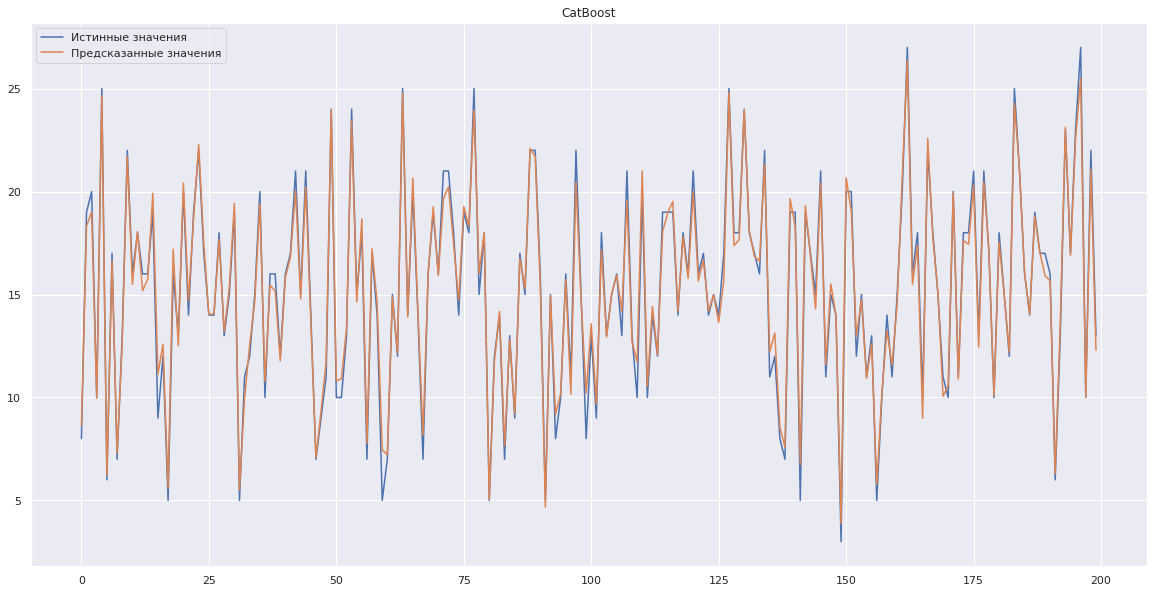

In [23]:
plot_test_pred(y_test, pred, "CatBoost")
print_metrics(y_test, pred)

$R^2$ уже очень близка к единице. Воспользуемся средствами `catboost`'a для просмотра уровней значимости параметров:

0: 26.546392060457592
1: 24.55416494471135
2: 11.446469947794068
3: 27.40581252169033
4: 9.333283706517083
5: 0.036091823719872594
6: 0.1880500938093286
7: 0.1122605486825668
8: 0.2967726105087615
9: 0.08070174210906206


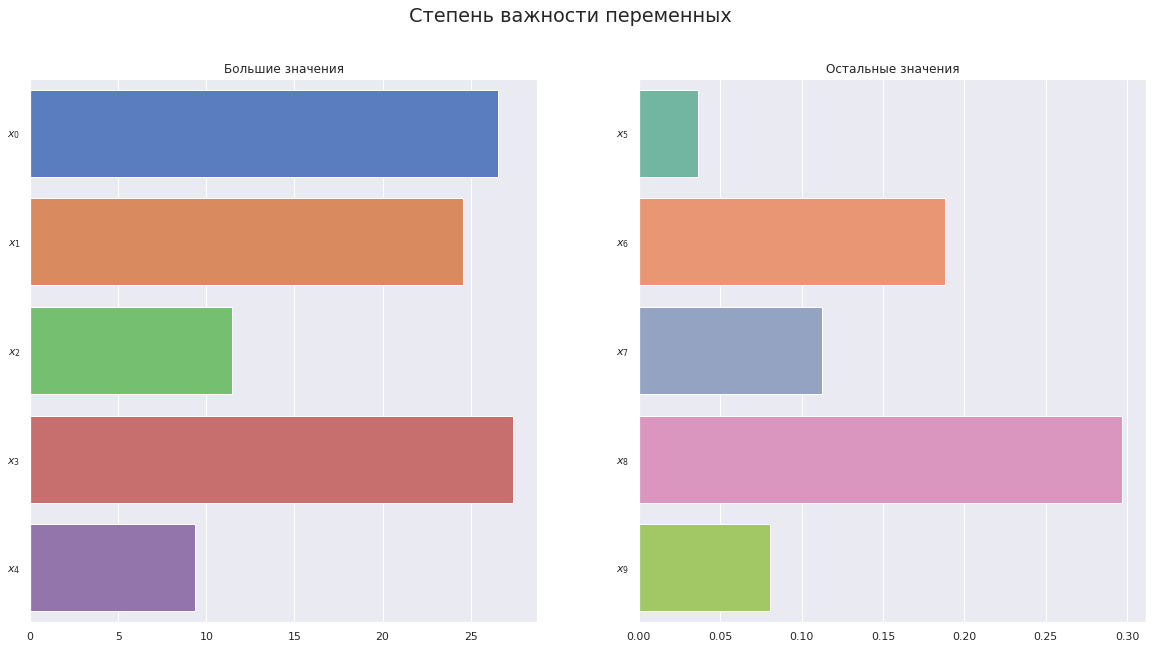

In [24]:
for i, e in enumerate(model.feature_importances_):
    print(f"{i}: {e}")
    
matplotlib.rcParams['font.size'] = 16.0

big = np.array(list(filter(lambda x: x[1] > 1, enumerate(model.feature_importances_))))
small = np.array(list(filter(lambda x: x[1] <= 1, enumerate(model.feature_importances_))))

big_labels = [f"$x_{int(i)}$" for i in big[:, 0]]
small_labels = [f"$x_{int(i)}$" for i in small[:, 0]]

sp = plt.subplot(1, 2, 1)

sns.barplot(x=big[:, 1], y=big_labels, palette="muted")
sp.set_title("Большие значения")

sp = plt.subplot(1, 2, 2)
sp.set_title("Остальные значения")

sns.barplot(x=small[:, 1], y=small_labels, palette="Set2")

plt.suptitle("Степень важности переменных")

plt.show()

Из диаграммы видно, что наибольшее влияние на предсказание оказывают переменные $x_0$, $x_1$, $x_2$, $x_3$ и $x_4$, а уровень значимости остальных на порядок ниже. Заметим, что это не те переменные, которые слабее всех коррелировали с $y$.

Попробуем теперь применить нейросеть.

In [25]:
import torch
torch.cuda.is_available()

True

Разделим датасет на три части: обучающую, валидационную и тестовую.

In [26]:
test_size = .2
test_bound = int(len(X) * (1 - test_size))
X_test = X[test_bound:]
y_test = y[test_bound:]
X_train, X_val, y_train, y_val = train_test_split(X[:test_bound], y[:test_bound], train_size=0.8)

In [27]:
X_train.shape, X_val.shape, X_test.shape

((640, 10), (160, 10), (200, 10))

In [28]:
y_train.shape, y_val.shape, y_test.shape

((640,), (160,), (200,))

In [29]:
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val)

In [30]:
train_dataset = torch.utils.data.TensorDataset(X_train_t, y_train_t)
val_dataset = torch.utils.data.TensorDataset(X_val_t, y_val_t)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, drop_last=True, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, drop_last=True)

In [31]:
from tqdm.notebook import trange

def train_model(model, loaders, optimizer, criterion, max_epochs=100):
    mse = {"train": [], "val": [], "r2": []}
    for epoch in trange(max_epochs):
        for k, dataloader in loaders.items():
            batch_losses = []
            for x_batch, y_batch in dataloader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch.view(-1, 1))                
                    loss.backward()
                    optimizer.step()
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch.float())

                batch_losses.append(criterion(outp, y_batch.view(-1, 1)).item())

                if k == "val":
                    loss = criterion(outp, y_batch.view(-1, 1)).item()
            mse[k].append(np.mean(batch_losses))
        mse["r2"].append(r2_score(y, model(torch.FloatTensor(X).to(device)).cpu().detach().numpy()))
    return mse

В качестве функции активации возьмём LeakyReLU, так как её производная почти нигде не равна нулю, и с ней не будет затухания градиента.

Эксперименты с количеством и размером слоёв показали, что лучше добавить побольше слоёв, чередуя размерность — то уменьшая её, то увеличивая.

Функция потерь — MSE, как и условились.

Метод оптимизации — Adam, так как даёт максимальный результат при минимальной настройке.

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.nn.Sequential(
    torch.nn.Linear(X_train.shape[1], 100),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(100, 500),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(500, 100),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(100, 500),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(500, 100),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(100, 500),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(500, 100),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(100, 500),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(500, 100),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(100, 500),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(500, 100),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(100, 500),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(500, 100),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(100, 500),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(500, 100),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(100, 10),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(10, 1)
).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "val": val_dataloader}

mse = train_model(model, loaders, optimizer, criterion, max_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

R^2: 0.97164605529514
MSE: 0.6429086838158778


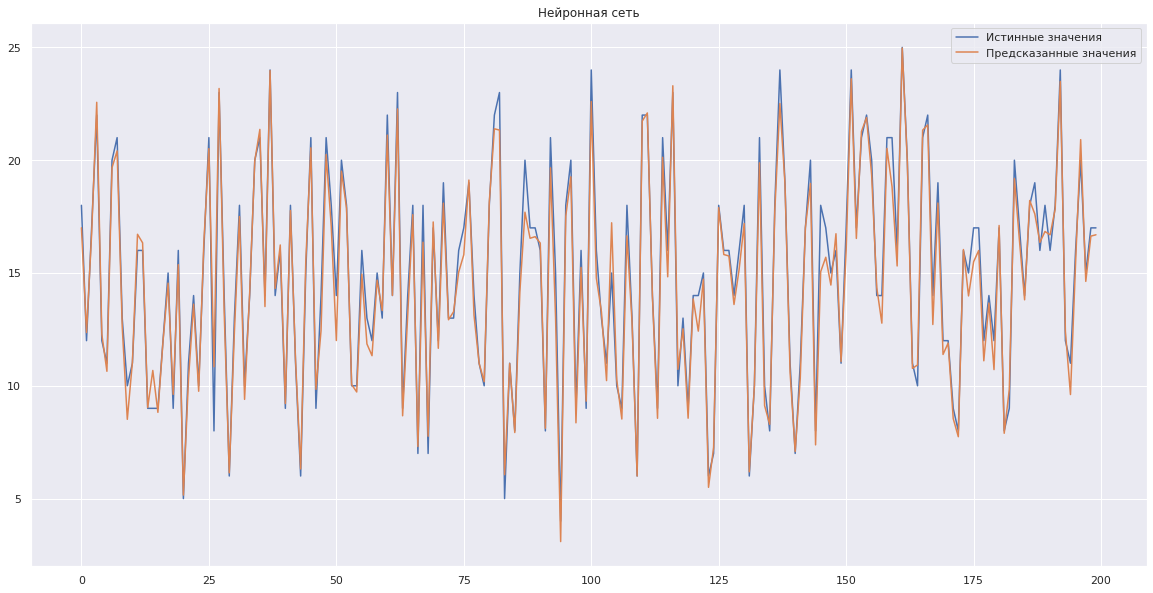

In [33]:
model.eval()

pred = model.forward(torch.Tensor(X_test).to(device)).cpu().detach().numpy()

plot_test_pred(y_test, pred, "Нейронная сеть")
print_metrics(y_test, pred)

Видим $R^2$, сравнимую с `catboost`'ом. На графике ниже можно видеть, как изменялись MSE и $R^2$ в процессе обучения.

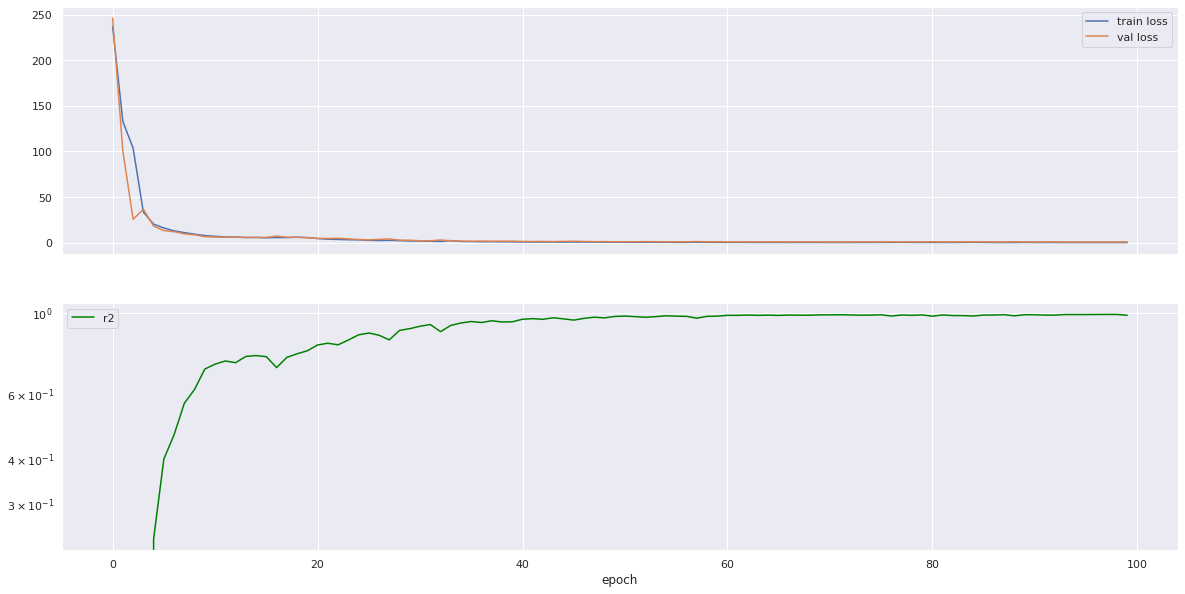

In [34]:
pl, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(mse["train"], label="train loss")
ax[0].plot(mse["val"], label="val loss")
ax[1].plot(mse["r2"], label="r2", color="green")
ax[1].set_yscale("log")
ax[0].legend()
ax[1].legend()
plt.xlabel("epoch")
plt.show()

## Идеи для улучшения результата

Лучшие результаты показали градиентный бустинг и нейросеть, поэтому стоит двигаться в направлении улучшения этих моделей.

Мы увидели, что среди параметров функции есть такие, уровень значимости которых на порядок ниже остальных. Можно попробовать исключить их из датасета и посмотреть, что произойдёт. Решающие деревья, на которых основан градиентный бустинг, избавившись от этих признаков, могут вывести более общие закономерности в данных и выдать лучший результат.

Можно поставить больше параметров для перебора в поиске по сетке для бустинга. Возможно, найдутся более оптимальные.

В нейросети можно ещё поменять количество слоёв и их размерность. Эксперименты показали, что с увеличением числа слоёв растёт и $R^2$. Можно предположить, что так сеть улавливает больше закономерностей в данных и показывает лучший результат.